# Setup

In [1]:
# Python 3 compatability
from __future__ import division, print_function

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg
import scipy
from scipy import stats

# plotting
import matplotlib
from matplotlib import pyplot as plt

# fits data
from astropy.io import fits

# inline plotting
%matplotlib inline

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 30})

# Star with 2 Bands: Joint Photometry

Load data.

In [3]:
nruns, ncolors, ntrials = 9, 4, 100000
sigclip = 5.

# effective area
psfwidth, noise = 2., 1.
aeff = 4. * np.pi * psfwidth**2
err = np.sqrt(aeff * noise**2)

# true values
f, f2, ferr, ftrials = np.zeros((4, nruns, ncolors))

# extract data
flux, fluxerr, x, y = np.zeros((4, nruns, ncolors, ntrials))
flux2, fluxerr2 = np.zeros((2, nruns, ncolors, ntrials))
for i in range(nruns):
    for j in range(ncolors):
        fname = 'data/sim_fit/run{0}.fits'.format(i * ncolors + j)  # run
        if os.path.isfile(fname):
            hdul = fits.open(fname)
            # grab true values
            f[i, j] = hdul[0].header['TRUEFLUX']  # true flux
            f2[i, j] = f[i, j] * hdul[0].header['TRUECOLR']  # second true flux
            psfwidth = hdul[0].header['PSFWIDTH']  # Gaussian PSF width
            noise = hdul[0].header['NOISE']  # iid Gaussian noise
            aeff = 4. * np.pi * psfwidth**2  # effective area
            ferr[i, j] = np.sqrt(aeff * noise**2)  # true error
            # grab trials
            data = hdul[1].data
            flux[i, j] = data['Flux']  # fluxes
            fluxerr[i, j] = data['Fluxerr']  # flux errors
            x[i, j], y[i, j] = data['X'], data['Y']  # positions
            flux2[i, j] = data['Flux2']  # fluxes
            fluxerr2[i, j] = data['Flux2Err']  # errors
            # clip suspicious trials
            pos = np.c_[x[i, j], y[i, j]]
            cinv = np.linalg.inv(np.cov(pos, rowvar=False))  # inv-cov
            sqdist = np.array([np.dot(np.dot(p, cinv), p) 
                               for p in pos])  # normalized distance
            sel = (sqdist <= sigclip**2) & (flux[i, j] / fluxerr[i, j] > 0.2)  # clip outliers
            flux[i, j, ~sel], fluxerr[i, j, ~sel] = np.nan, np.nan
            x[i, j, ~sel], y[i, j, ~sel] = np.nan, np.nan
            flux2[i, j, ~sel], fluxerr2[i, j, ~sel] = np.nan, np.nan
            ftrials[i, j] = len(sel)
        else:
            print(fname + ' not found.')

data/sim_fit/run31.fits not found.
data/sim_fit/run33.fits not found.
data/sim_fit/run35.fits not found.


In [4]:
# define relevant quantities

snr = f / ferr  # true SNR (band 1)
favg, fstd = np.nanmean(flux, axis=2), np.nanstd(flux, axis=2)
fbias_avg = (favg - f) / f  # fractional bias
fbias_err = fstd / f / np.sqrt(ftrials)  # uncertainty

snr2 = f2 / ferr  # true SNR (band 2)
favg2, fstd2 = np.nanmean(flux2, axis=2), np.nanstd(flux2, axis=2)
fbias_avg2 = (favg2 - f2) / f2  # fractional bias
fbias_err2 = fstd2 / f2 / np.sqrt(ftrials)  # uncertainty

snr_eff = np.sqrt(snr**2 + snr2**2)

cbias_avg = np.nanmedian(-2.5 * np.log10(flux / flux2), axis=2) + 2.5 * np.log10(f / f2)
cbias_sel = np.isnan(-2.5 * np.log10(flux / flux2)).sum(axis=2) < 0.02 * ntrials
cbias_std = np.nanstd(-2.5 * np.log10(flux / flux2), axis=2) / np.sqrt(ftrials)

/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back

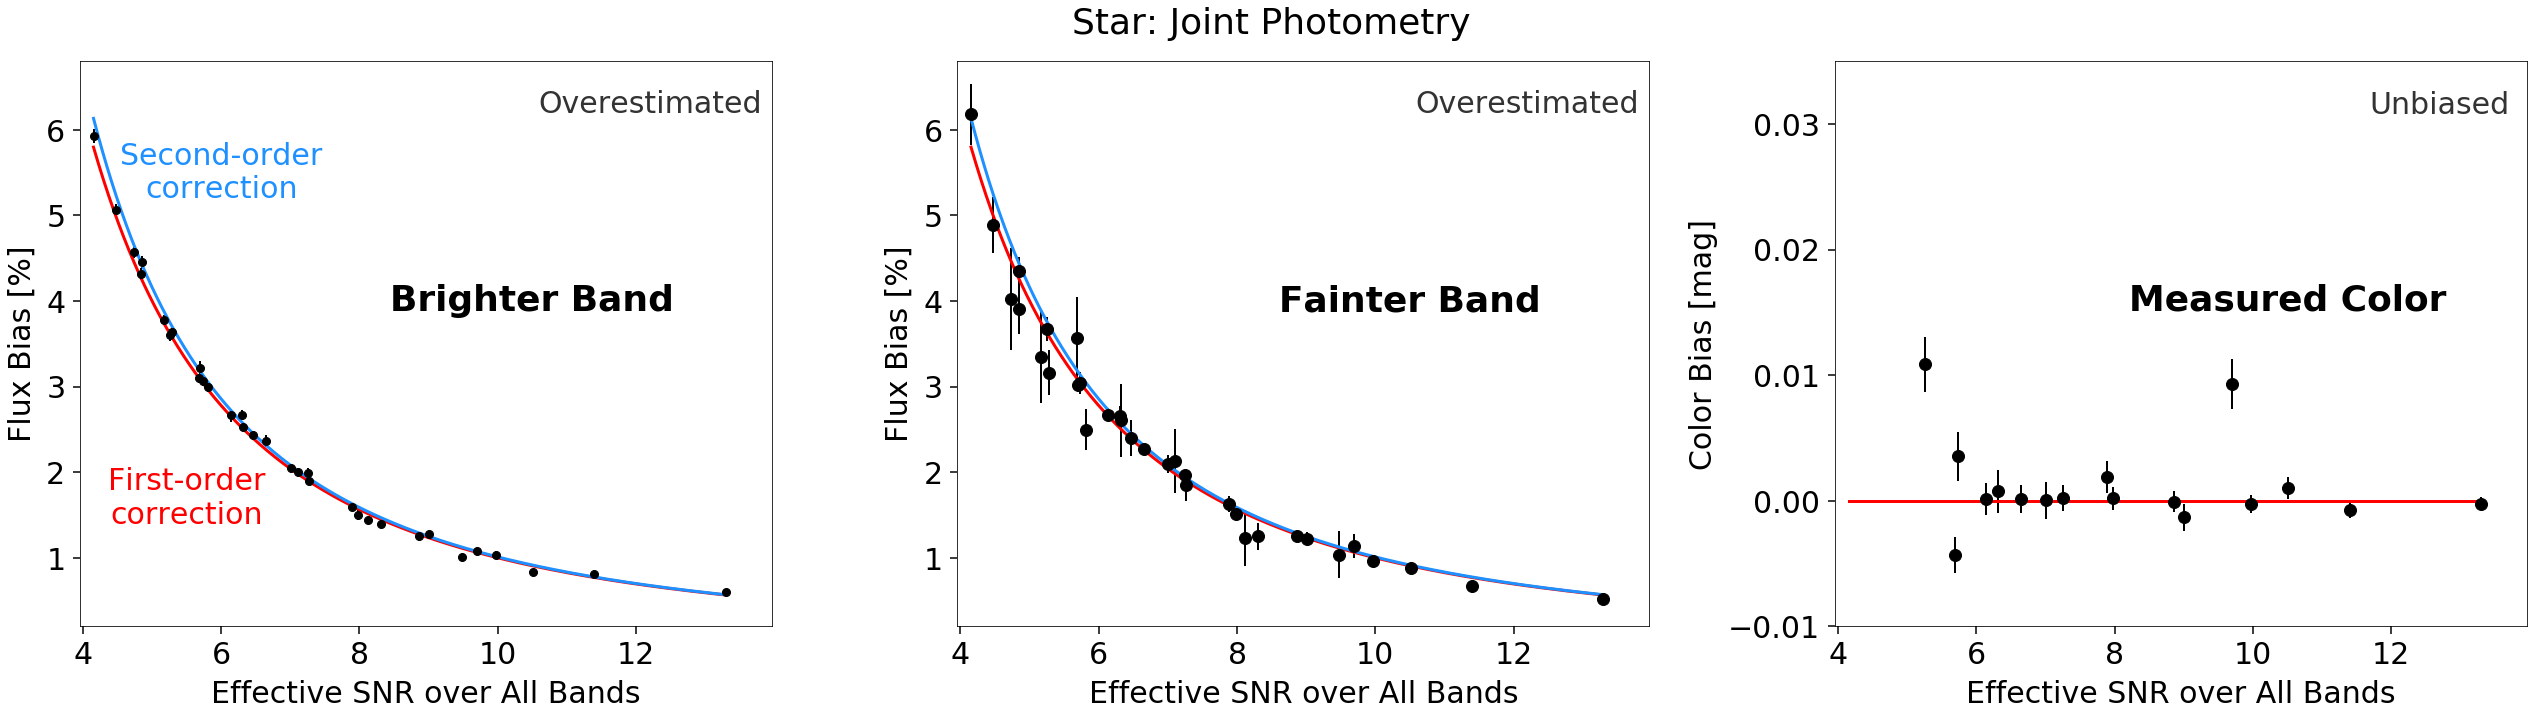

In [5]:
snr_grid = np.linspace(np.nanmin(snr_eff), np.nanmax(snr_eff), 1000)

# plot flux bias + variance
plt.figure(figsize=(36, 10))
plt.suptitle('Star: Joint Photometry', y=1.02)

# flux (band 1)
plt.subplot(1, 3, 1)
plt.errorbar(snr_eff.flatten(),
             fbias_avg.flatten() * 100., 
             yerr=fbias_err.flatten() * 100.,
             marker='o', color='black', 
             linestyle='none', markersize=8,
             elinewidth=2)  # avg fractional bias
plt.plot(snr_grid, snr_grid**-2 * 100., 
         linestyle='-', color='red', 
         label='1st-order', lw=3)  # 1st-order correction
plt.plot(snr_grid, (snr_grid**-2 + snr_grid**-4) * 100., 
         linestyle='-', color='dodgerblue',
         label='2nd-order', lw=3)  # 2nd-order correction
# label
plt.text(5.5, 1.7, 'First-order\ncorrection', 
         horizontalalignment='center', verticalalignment='center',
         color='red')
plt.text(6, 5.5, 'Second-order\ncorrection', 
         horizontalalignment='center', verticalalignment='center',
         color='dodgerblue')
# prettify
plt.text(12.2, 6.3, 'Overestimated',
         horizontalalignment='center', verticalalignment='center',
         color='black', alpha=0.8)
plt.text(10.5, 4.0, 'Brighter Band', weight='bold', fontsize='large',
         horizontalalignment='center', verticalalignment='center',
         color='black')
plt.xlabel(r'Effective SNR over All Bands', labelpad=10)
plt.ylabel(r'Flux Bias [%]', labelpad=10)
plt.xlim(np.nanmin(snr_eff) / 1.05, np.nanmax(snr_eff) * 1.05)
plt.ylim([0.2, 6.8])
plt.tight_layout()

# flux (band 2)
plt.subplot(1, 3, 2)
plt.errorbar(snr_eff.flatten(), fbias_avg2.flatten() * 100., 
             yerr=fbias_err2.flatten() * 100.,
             marker='o', color='black', 
             linestyle='none', markersize=12,
             elinewidth=2)  # avg fractional bias
plt.plot(snr_grid, snr_grid**-2 * 100., 
         linestyle='-', color='red', 
         label='1st-order', lw=3)  # 1st-order correction
plt.plot(snr_grid, (snr_grid**-2 + snr_grid**-4) * 100., 
         linestyle='-', color='dodgerblue',
         label='2nd-order', lw=3)  # 2nd-order correction
# prettify
plt.text(12.2, 6.3, 'Overestimated',
         horizontalalignment='center', verticalalignment='center',
         color='black', alpha=0.8)
plt.text(10.5, 4.0, 'Fainter Band', weight='bold', fontsize='large',
         horizontalalignment='center', verticalalignment='center',
         color='black')
plt.xlabel(r'Effective SNR over All Bands', labelpad=10)
plt.ylabel(r'Flux Bias [%]', labelpad=10)
plt.xlim(np.nanmin(snr_eff) / 1.05, np.nanmax(snr_eff) * 1.05)
plt.ylim([0.2, 6.8])
plt.tight_layout()

# color (band 1 - band 2)
plt.subplot(1, 3, 3)
plt.errorbar((snr_eff)[cbias_sel], cbias_avg[cbias_sel], 
             yerr=cbias_std[cbias_sel],
             marker='o', color='black', 
             linestyle='none', markersize=12,
             elinewidth=2)  # avg fractional bias
plt.plot(snr_grid, np.zeros_like(snr_grid),
         linestyle='-', color='red', 
         label='1st-order', lw=3)  # 1st-order correction
# prettify
plt.text(12.7, 0.0315, 'Unbiased',
         horizontalalignment='center', verticalalignment='center',
         color='black', alpha=0.8)
plt.text(10.5, 0.016, 'Measured Color', weight='bold', fontsize='large',
         horizontalalignment='center', verticalalignment='center',
         color='black')
plt.xlabel(r'Effective SNR over All Bands', labelpad=10)
plt.ylabel(r'Color Bias [mag]', labelpad=10)
plt.xlim(np.nanmin(snr_eff) / 1.05, np.nanmax(snr_eff) * 1.05)
plt.ylim([-0.01, 0.035])
plt.tight_layout()

# save figure
plt.savefig('plots/star_joint.png', bbox_inches='tight')